In [31]:
from netCDF4 import Dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sensor_helper import *
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, confusion_matrix, r2_score
from sklearn.model_selection import TimeSeriesSplit, KFold
from sklearn.pipeline import make_pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegressionCV, RidgeCV, LogisticRegression
from sklearn.preprocessing import RobustScaler
from tqdm import tqdm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
def put_gnb_on_grid(grid, clf_list, gnb_idx=0):
    grid_clf = np.zeros(grid.shape)
    for gg, clf in zip(np.unique(grid), clf_list):
        grid_clf[grid==gg] = clf.named_steps['gaussiannb'].theta_[gnb_idx]
    
    return grid_clf


def put_lda_on_grid(grid, clf_list):
    grid_clf = np.zeros(grid.shape)
    for gg, clf in zip(np.unique(grid), clf_list):
        grid_clf[grid==gg] = clf.named_steps['lineardiscriminantanalysis'].coef_[0]
    
    return grid_clf


def preprocess_data_grid(data, grid, len_lat=96, len_lon=192):
    '''
    Keep in mind that grid indicates which features correspond to which 
    classifier. If reshaping data, the grid needs to be changed accordingly.
    '''
    data_flat = np.array(data.reshape(-1, len_lat * len_lon))
    grid_flat = grid.reshape(-1)
    
    return data_flat, grid_flat


def put_scores_on_grid(grid, scores):
    grid_clf = np.zeros(grid.shape)
    for gg, sc in zip(np.unique(grid), scores):
        grid_clf[grid==gg] = sc
    
    return grid_clf


# Prepare hold_out data
def score_on_hold_out(X, y, final_clfs, grid, len_lat=96, len_lon=192, 
                      metric=roc_auc_score, scores_index=None, proba=True):

    X = load_simulation(X)[0]
    X, grid = preprocess_data_grid(X, grid)

    predictions = predict_on_grid(X, y, final_clfs, grid, proba=proba)

    scores = score_on_grid(y, predictions, metric)
    if scores_index is not None:
        avg_pred =  predictions[:, scores_index].mean(1)
    else:
        avg_pred = predictions.mean(1)
    
    score_avg = metric(y, avg_pred)
    
    return predictions, scores, avg_pred, score_avg



def run_grid_classification(X, y, grid, cv, clf, metric=roc_auc_score, proba=True, best_vals=False):
    X = load_simulation(X)[0]
    X, grid = preprocess_data_grid(X, grid)
    
    predictions = np.zeros((y.shape[0], np.unique(grid).shape[0]))
    scores = np.zeros((TSS.n_splits, np.unique(grid).shape[0]))
    clf_list = []

    for train_index, test_index in tqdm(TSS.split(X)):

        cv_clf_list = []

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        curr_clf = fit_on_grid(X_train, y_train, clf, grid)

        predictions[test_index, :] = predict_on_grid(X_test, y_test, curr_clf, grid, proba=proba)

        clf_list.append(curr_clf)

    scores = score_on_grid(y[np.int(X.shape[0] / n_splits) : ],
                           predictions[np.int(X.shape[0] / n_splits):, :], metric)

    # Select best grids:
    scores_idx = scores > np.percentile(scores, 75)
    
    if not best_vals:
        avg_pred = np.mean(predictions[:, scores_idx], 1)
    else:
        avg_pred = np.mean(predictions, 1)
        
    print("Average Score")
    print(metric(y, avg_pred))
    ## After cross-validation fit on all data:
    final_clfs = fit_on_grid(X, y, clf, grid)
    
    return final_clfs, clf_list, scores, predictions, scores_idx


In [3]:
data, lat, lon = load_simulation('R1')
# Store the lenght
len_lat = lat.shape[0]
len_lon = lon.shape[0]
VOL =  Dataset('data/Volc_Forc_AOD_1st_mill.nc', 'r')['AOD'][:, 0, 0]
SUN =  Dataset('data/Solar_forcing_1st_mill.nc', 'r')['TSI'][:, 0, 0]

## Sensor array subdivides map into even spaces
The idea is to subdivide our map into sub areas and train a classifier on each sub area. 

In [4]:
sensor_grid = sensor_fields(len_lat, len_lon, 6, 6)

In [5]:
# Really hacky but it might do the trick
SUN_min = pd.DataFrame(SUN, columns=['SUN'])['SUN'].rolling(window=11,center=True,min_periods=1).min().values
VOL_max = pd.DataFrame(VOL, columns=['VOL'])['VOL'].rolling(window=11,center=True,min_periods=1).max().values
# Featurize SUN time:
SUN_class = SUN == SUN_min
VOL_class = np.logical_and(VOL == VOL_max, VOL_max != 0)

In [6]:
len_lon

192

In [36]:
# Cross validation - split data:
# Splitting the data into 4s
n_splits = 4
TSS = TimeSeriesSplit(n_splits=n_splits)

y = SUN_class
cv = TSS
clf = make_pipeline(RobustScaler(), LogisticRegression())

In [37]:
final_clfs, _, scores_cv, _, sc_idx = run_grid_classification('R1', y, sensor_grid, cv, clf, 
                                                         proba=False, metric=roc_auc_score);



0it [00:00, ?it/s]/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-lea

/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

Average Score
0.5475208207790602


/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/mnt/d/MinicondaLinux/envs/HIDA/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modu

In [42]:
scores = score_on_hold_out('R2', y, final_clfs, sensor_grid, proba=False, 
                           metric=roc_auc_score, scores_index=sc_idx)[1]

In [43]:
scores

array([0.50448477, 0.4953414 , 0.49537616, 0.50403282, 0.49329022,
       0.50003477, 0.50239883, 0.49840078, 0.51797386, 0.50253789,
       0.49509804, 0.49794882, 0.50152969, 0.48793631, 0.50187735,
       0.49805312, 0.49596718, 0.50066055, 0.50267696, 0.50396329,
       0.50448477, 0.50511055, 0.49353358, 0.50358086, 0.48970936,
       0.49680156, 0.48352107, 0.489466  , 0.48320818, 0.50302461,
       0.51404533, 0.49155194, 0.48880545, 0.49593242, 0.50813517,
       0.49527187])

In [44]:
sc1 = put_scores_on_grid(sensor_grid, scores)
sc2 = put_scores_on_grid(sensor_grid, scores_cv)

(<Figure size 1080x360 with 2 Axes>,
 array([<cartopy.mpl.geoaxes.GeoAxesSubplot object at 0x7fbd8467c2d0>,
       dtype=object))

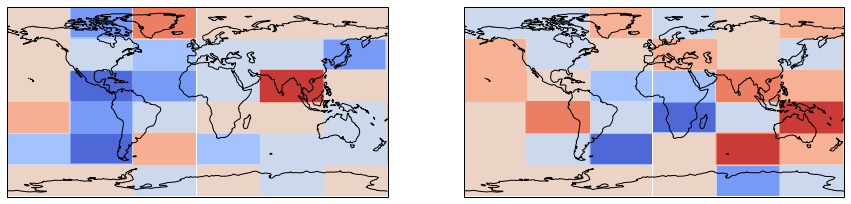

In [45]:
plot_maps([sc1, sc2], lon, lat)

In [30]:
scores_cv

array([-0.05104114, -0.08380324, -0.14477325, -0.07458698, -0.13659431,
       -0.09695015, -0.07102339, -0.08972088, -0.12294969, -0.08479909,
       -0.13746965, -0.08233307, -0.06539134, -0.06763937, -0.03321518,
       -0.08801518, -0.16948475, -0.11862329, -0.04920545, -0.09099367,
       -0.03718477, -0.04432292, -0.17302602, -0.06315833, -0.07856215,
       -0.12448285, -0.08825671, -0.07190713, -0.14574976, -0.08921819,
       -0.08875906, -0.17376245, -0.10268503, -0.07192838, -0.09077593,
       -0.05420782])

In [23]:
scores[sc_idx]

array([-0.90145119, -0.91523966, -1.57574866, -1.07073082, -1.13918084,
       -0.79400525, -1.06422468, -1.2665027 , -1.00961022])

In [12]:
TSS.n_splits

4